<a href="https://colab.research.google.com/github/gopaps/MachineLearning/blob/main/week%207/Worksheet_of_7_XGBoost_tugasxgboost.csv__Anda_Figo_Haq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learn on how to build and optimize model with **gradient boosting.**

#Introduction
By definition, **ensemble methods** combine the predictions of several models (e.g., several trees, in the case of random forest).

Now, we'll learn about another ensemble method called gradient boosting.

#Difference of Decision Tree, Random Forest, and XGBoost

1. Decision Tree:
A decision tree is a simple and interpretable model that recursively splits the data into subsets based on the feature values. It forms a tree-like structure where each internal node represents a test on a feature, each branch represents the outcome of that test, and each leaf node represents the final prediction. The decision tree makes binary decisions at each node to split the data. It is prone to overfitting, especially when the tree becomes deep, capturing noise and leading to poor generalization on unseen data.

2. Random Forest:
Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions through voting (for classification) or averaging (for regression). Each decision tree is trained on a random subset of the data (bootstrap sample) and a random subset of the features. This randomness reduces overfitting and increases the model's ability to generalize to new data.

3. XGBoost (Extreme Gradient Boosting):
XGBoost is an optimized implementation of the Gradient Boosting algorithm. It creates an ensemble of weak learners (usually shallow decision trees) sequentially, where each new model corrects the errors made by the previous one. XGBoost uses a gradient-based optimization algorithm to minimize a loss function while adding new trees to the ensemble. It also includes regularization terms to control overfitting and speed up the training process. XGBoost is known for its high performance, scalability, and efficiency, making it popular in various machine learning competitions and real-world applications.
**XGBoost** is an implementation of gradient boosting with several additional features focused on perfmance and speed. The final result of an XGBoost model is a weighted sum of the predictions made by all the individual trees in the sequence. The contribution of each tree is adjusted during training based on how well it reduces the overall error.


Note:

* Regularization (penyederhanaan): XGBoost introduces regularization terms to control overfitting during the training process. Regularization helps prevent the model from becoming too complex and ensures better generalization to unseen data.


#Gradient Boosting

**Gradient boosting** is a method that goes through cycles to iteratively add models into an ensemble (setelan).

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent (kemudian) additions to the ensemble will address those errors.)

Then, we start the cycle:
1. First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we **add the predictions from all models** in the ensemble.
2. These predictions are used to calculate a loss function (like mean squared error, for instance).
3. Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss.
4. Finally, we add the new model to ensemble, and ...
5. Repeat!

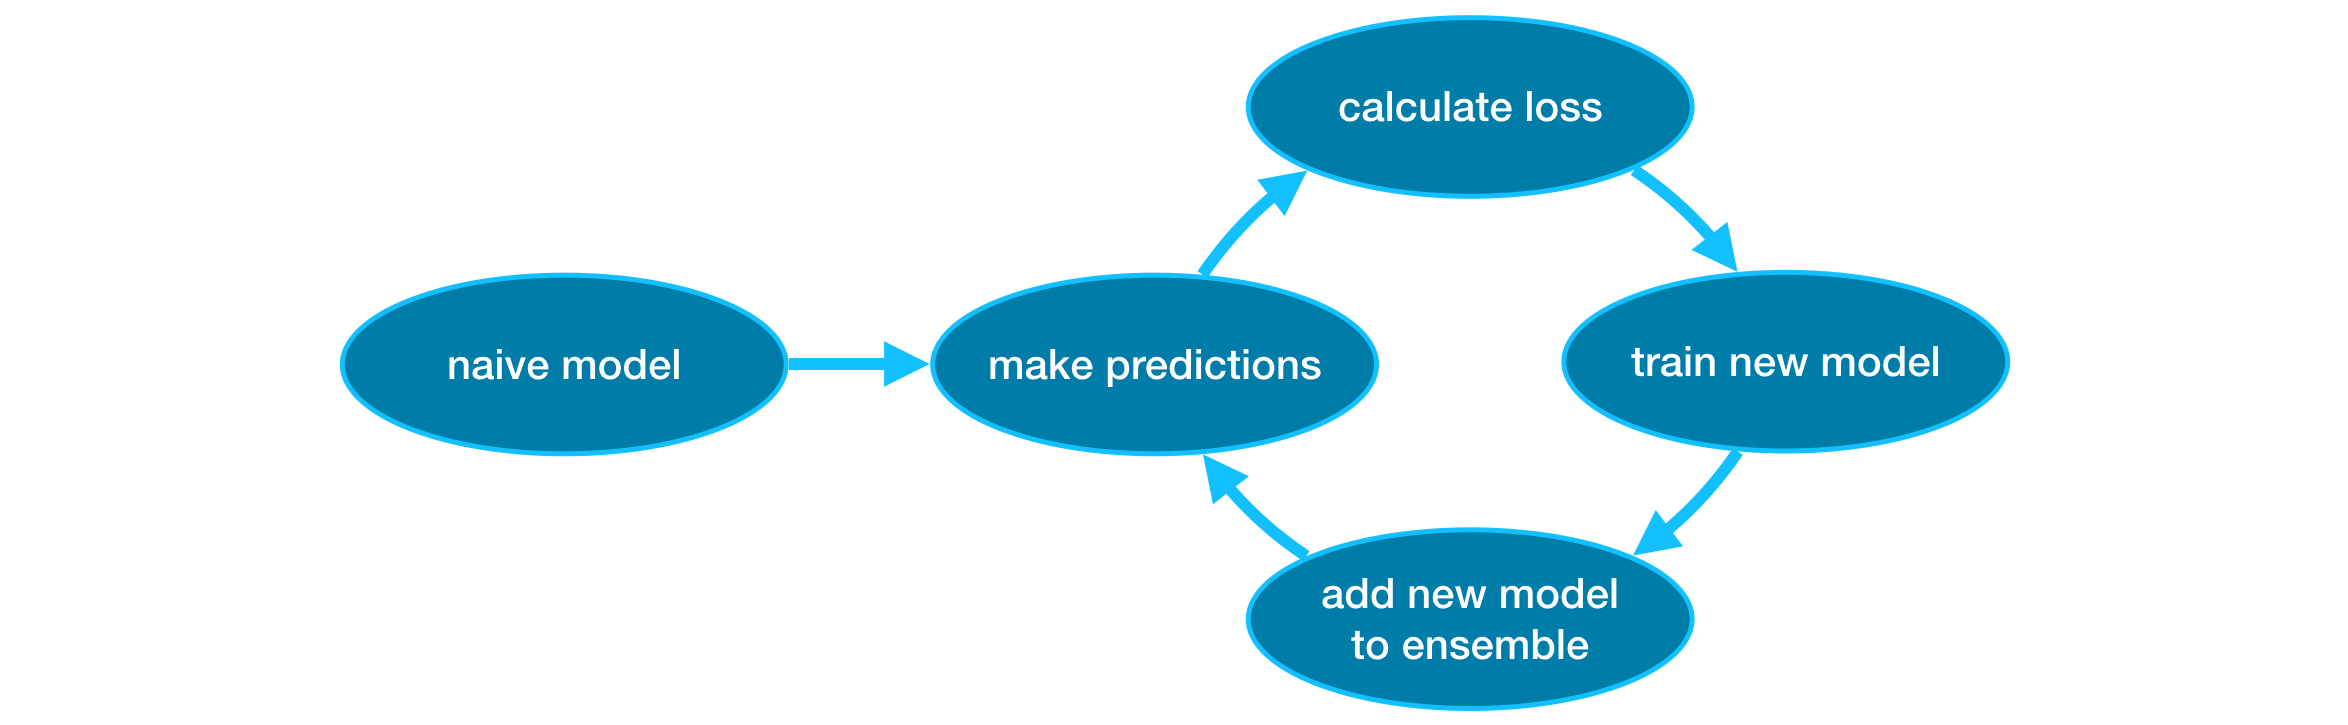

#Example
We begin by loading the training and validation data in X_train, X_valid, y_train, y_valid.

**Prompt:**

Write a code cell to mount Google Drive in Colab.

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Definisikan path ke file tugasxgboost.csv
file_path = '/content/drive/My Drive/dataset/tugasxgboost.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Prompt:**

Write a code cell to read a CSV file from Google Drive into a DataFrame.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
from sklearn.inspection import PartialDependenceDisplay
# Definisikan path ke file CSV
file_path = '/content/drive/My Drive/dataset/tugasxgboost.csv'

# Membaca file CSV ke dalam DataFrame
df = pd.read_csv(file_path)

# Tampilkan 5 baris pertama dari DataFrame
print(df.head())


     X1    X2    X3   X4    X5    X6    X7        X8    X9   X10  X11  Class
0   7.4  0.70  0.00  1.9  76.0  11.0  34.0    0.9978  3.51  0.56  9.4      5
1   7.8  0.88  0.00  2.6  98.0  25.0  67.0    0.9968  3.20  0.68  9.8      5
2   7.8  0.76  0.04  2.3  92.0  15.0  54.0  997.0000  3.26  0.65  9.8      5
3  11.2  0.28  0.56  1.9  75.0  17.0  60.0  998.0000  3.16  0.58  9.8      6
4   7.4  0.70  0.00  1.9  76.0  11.0  34.0    0.9978  3.51  0.56  9.4      5


**Prompt:**

Write a code cell to select a subset of predictors ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt'] and set the target variable ['Price'] from the DataFrame.

In [ ]:
# Memilih kolom prediktor
predictors = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']
X = df[predictors]

# Menetapkan variabel target
target = 'Class'
y = df[target]

# Menampilkan informasi tentang X dan y
print("Prediktor yang dipilih (X):")
print(X.head())
print("\nVariabel target (y):")
print(y.head())


Prediktor yang dipilih (X):
     X1    X2    X3   X4    X5    X6    X7        X8    X9   X10  X11
0   7.4  0.70  0.00  1.9  76.0  11.0  34.0    0.9978  3.51  0.56  9.4
1   7.8  0.88  0.00  2.6  98.0  25.0  67.0    0.9968  3.20  0.68  9.8
2   7.8  0.76  0.04  2.3  92.0  15.0  54.0  997.0000  3.26  0.65  9.8
3  11.2  0.28  0.56  1.9  75.0  17.0  60.0  998.0000  3.16  0.58  9.8
4   7.4  0.70  0.00  1.9  76.0  11.0  34.0    0.9978  3.51  0.56  9.4

Variabel target (y):
0    5
1    5
2    5
3    6
4    5
Name: Class, dtype: int64


**Prompt:**

Write a code cell to split the data into training and validation

In [ ]:
# Import train_test_split from scikit-learn
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Displaying the shape of the training and validation sets
X_train.shape, X_val.shape, y_train.shape, y_val.shape


((1279, 11), (320, 11), (1279,), (320,))

In the next code cell, we import the scikit-learn API for XGBoost (`xgboost.XGBRegressor`). As you'll see in the output, the `XGBRegressor` class has many tunable parameters.


**Prompt:**

Write a code cell to train the model using XGBoost, and print the mean absolute error on the validation set.

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
# Importing XGBoost and mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Training the XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

# Making predictions on the validation set
predictions = model.predict(X_val)

# Calculating mean absolute error
mae = mean_absolute_error(y_val, predictions)
print(f"Mean Absolute Error on validation set: {mae}")


Mean Absolute Error on validation set: 0.41977919936180114


We also make predictions and evaluate the model.

#Parameter Tuning
XGBoost has a few parameters that can dramatically affect accuracy and training speed. The first parameters you should understand are:

`n_estimators`
Specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.
* Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
* Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

Typical values range from 100-1000, though this depends a lot on the `learning_rate` parameter discussed below.

Here is the code to set the number of models in the ensemble:

**Prompt:**

Write a code cell to create another XGBRegressor with 500 estimators, train it, and print the mean absolute error on the validation set.

In [ ]:
# Training another XGBRegressor with 500 estimators
model_500 = XGBRegressor(n_estimators=500)
model_500.fit(X_train, y_train)

# Making predictions on the validation set
predictions_500 = model_500.predict(X_val)

# Calculating mean absolute error
mae_500 = mean_absolute_error(y_val, predictions_500)
print(f"Mean Absolute Error on validation set with 500 estimators: {mae_500}")


Mean Absolute Error on validation set with 500 estimators: 0.41319652944803237


The MAE result of the model with n_estimators set to 500 turned out to be greater than the default value of n_estimators, which is 100.

The MAE (Mean Absolute Error) of the model with an n_estimators value of 110 turns out to be smaller than the default n_estimators value of 100, as well as n_estimators with a value of 500.

`early_stopping_rounds`
offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stop improving, even if we aren't the hard stop for `n_estimators`. It's smart to set a high value for `n_estimators` and then use `early_stopping_rounds` to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration (keburukan) to allow before stopping. Setting `early_stopping_rounds=5` is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.

When using `early_stopping_rounds`, you also need to set aside some data for calculating the validation scores. This is done by setting the `eval_set` parameter.

We can modify the example above to include early stopping.

---
Note:

* In the context of training machine learning models, "deteriorating" refers to a situation where the performance of the model on a validation dataset worsens over consecutive iterations during the training process. Typically, we monitor a metric (such as accuracy, mean squared error, etc.) on the validation dataset to evaluate the model's performance.

* In the given code, verbose=False is an argument passed to the fit method of the XGBRegressor model. Setting verbose to False means that during the training process, the model will not produce any output or progress messages. It will train silently without displaying information about each boosting round.

`n_jobs`

On larger datasets where runtime is a consideration, you can use parallelism to build your model faster. It's common to set the parameter `n_jobs` equal to the number of cores on your machine. On smaller datasets, this won't help.
The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the `fit` command.

Here's the modified example.

**Prompt:**

Write a code cell to train an XGBRegressor with a custom learning rate, 90 estimators, and early stopping rounds, and print the mean absolute error on the validation set.

In [ ]:
# Mengimpor library yang diperlukan
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Inisialisasi model dengan learning rate dan estimators
model_custom = XGBRegressor(n_estimators=90, learning_rate=0.1, eval_metric="mae")

# Melatih model tanpa early stopping, kemudian kita akan melakukan validasi secara manual
model_custom.fit(X_train, y_train)

# Membuat prediksi pada set validasi
predictions_custom = model_custom.predict(X_val)

# Menghitung mean absolute error pada set validasi
mae_custom = mean_absolute_error(y_val, predictions_custom)
print(f"Mean Absolute Error pada set validasi: {mae_custom}")


Mean Absolute Error pada set validasi: 0.4393461763858795


In [ ]:
# Mengimpor library untuk mount Google Drive
from google.colab import drive

# Mount Google Drive untuk mengakses file
drive.mount('/content/drive')

# Definisikan path ke file CSV di Google Drive
file_path = '/content/drive/My Drive/dataset/tugasxgboost.csv'

# Membaca file CSV ke dalam DataFrame
import pandas as pd
df = pd.read_csv(file_path)

# Menampilkan beberapa baris pertama dari DataFrame untuk memeriksa data
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Class
0,7.4,0.70,0.00,1.9,76.0,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,98.0,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,92.0,15.0,54.0,997.0000,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,75.0,17.0,60.0,998.0000,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,76.0,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
# Menetapkan kolom prediktor dan target
predictors = ['X1', 'X2', 'X3', 'X4', 'X5']  # Kolom fitur
target = 'Class'  # Kolom target

# Memisahkan fitur (X) dan target (y)
X = df[predictors]
y = df[target]

# Menampilkan beberapa baris dari X dan y untuk verifikasi
X.head(), y.head()


(     X1    X2    X3   X4    X5
 0   7.4  0.70  0.00  1.9  76.0
 1   7.8  0.88  0.00  2.6  98.0
 2   7.8  0.76  0.04  2.3  92.0
 3  11.2  0.28  0.56  1.9  75.0
 4   7.4  0.70  0.00  1.9  76.0,
 0    5
 1    5
 2    5
 3    6
 4    5
 Name: Class, dtype: int64)

In [ ]:
# Mengimpor XGBRegressor untuk model XGBoost dan mean_absolute_error untuk evaluasi
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Inisialisasi model XGBoost dengan parameter dasar
model = XGBRegressor()
model.fit(X_train, y_train)  # Melatih model dengan data pelatihan

# Membuat prediksi pada data validasi
predictions = model.predict(X_val)

# Menghitung Mean Absolute Error pada set validasi
mae = mean_absolute_error(y_val, predictions)
print(f"Mean Absolute Error pada set validasi: {mae}")


Mean Absolute Error pada set validasi: 0.41977919936180114


In [ ]:
# Melatih model XGBRegressor dengan 500 estimators
model_500 = XGBRegressor(n_estimators=500)
model_500.fit(X_train, y_train)

# Membuat prediksi pada data validasi
predictions_500 = model_500.predict(X_val)

# Menghitung Mean Absolute Error
mae_500 = mean_absolute_error(y_val, predictions_500)
print(f"Mean Absolute Error pada set validasi dengan 500 estimators: {mae_500}")


Mean Absolute Error pada set validasi dengan 500 estimators: 0.41319652944803237


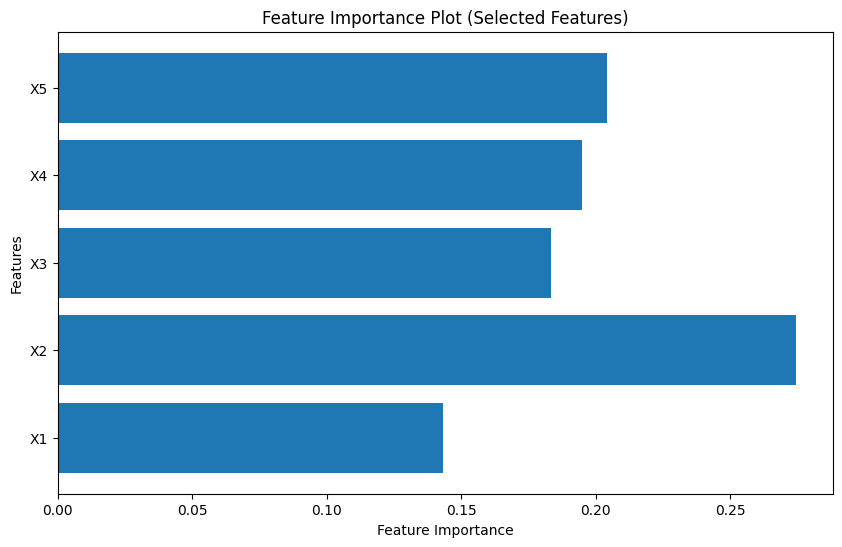

In [ ]:
# Melatih ulang model hanya dengan fitur yang dipilih
model_selected = XGBRegressor()
model_selected.fit(X[predictors], y)

# Membuat plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(predictors, model_selected.feature_importances_)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot (Selected Features)")
plt.show()


Fitur X2 memiliki kontribusi terbesar terhadap prediksi model. Ini menunjukkan bahwa fitur ini paling penting atau paling berpengaruh dalam menentukan hasil prediksi. Dengan kata lain, perubahan dalam nilai X2 kemungkinan besar akan berdampak signifikan pada output model.

Fitur X5 dan X4 juga memiliki kontribusi yang cukup besar, meskipun lebih kecil dari X2. Kedua fitur ini dapat dianggap penting, tetapi pengaruhnya tidak sebesar X2.

Fitur X1 dan X3 memiliki kontribusi yang lebih rendah dibandingkan fitur lainnya. Artinya, perubahan pada X1 dan X3 mungkin tidak terlalu berdampak besar pada prediksi model dibandingkan dengan X2, X4, dan X5.

Prioritas Analisis Lebih Lanjut: Jika Anda ingin mengoptimalkan model atau memahami data lebih dalam, Anda dapat memprioritaskan analisis pada fitur X2, X4, dan X5, karena mereka memiliki pengaruh terbesar terhadap model.

Penghapusan Fitur Kurang Signifikan: Jika diperlukan untuk menyederhanakan model atau mengurangi dimensi data, fitur dengan kontribusi yang lebih rendah (seperti X1 dan X3) mungkin bisa dipertimbangkan untuk dihapus, tergantung pada kebutuhan analisis dan performa model.

Secara keseluruhan, grafik ini membantu kita memahami fitur mana yang paling memengaruhi model, memungkinkan kita untuk lebih fokus pada fitur utama dalam analisis atau pengembangan model selanjutnya.

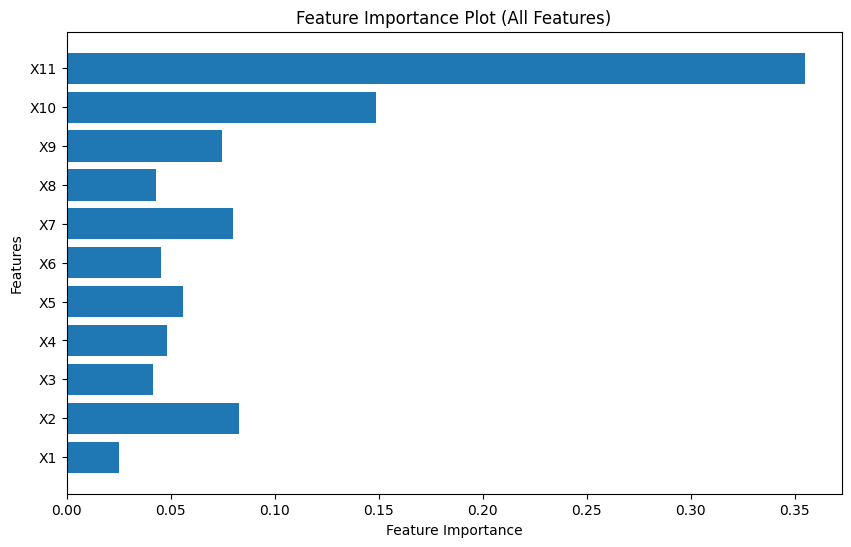

In [ ]:
# Membuat plot feature importance untuk semua fitur
plt.figure(figsize=(10, 6))
plt.barh(df.columns[:-1], model.feature_importances_)  # Menggunakan semua kolom kecuali target
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot (All Features)")
plt.show()


Secara keseluruhan, grafik ini menunjukkan bahwa model sangat bergantung pada fitur X11 dan X10 untuk membuat prediksi.








<Figure size 2000x2000 with 0 Axes>

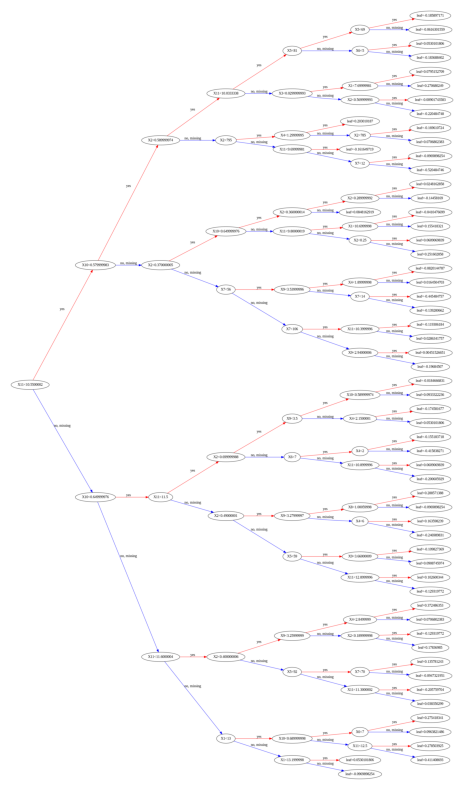

In [ ]:
# Mengimpor plot_tree dari XGBoost
from xgboost import plot_tree

# Menampilkan struktur dari pohon pertama di model
plt.figure(figsize=(20, 20))
plot_tree(model, num_trees=0, rankdir='LR')
plt.show()


Fitur yang sering muncul di level atas adalah yang paling penting dalam memengaruhi prediksi.
Kedalaman pohon menunjukkan kompleksitas model, yang dapat meningkatkan risiko overfitting.
Warna dan ketebalan cabang menunjukkan kekuatan keputusan, dengan cabang yang lebih tebal memiliki pengaruh lebih besar.

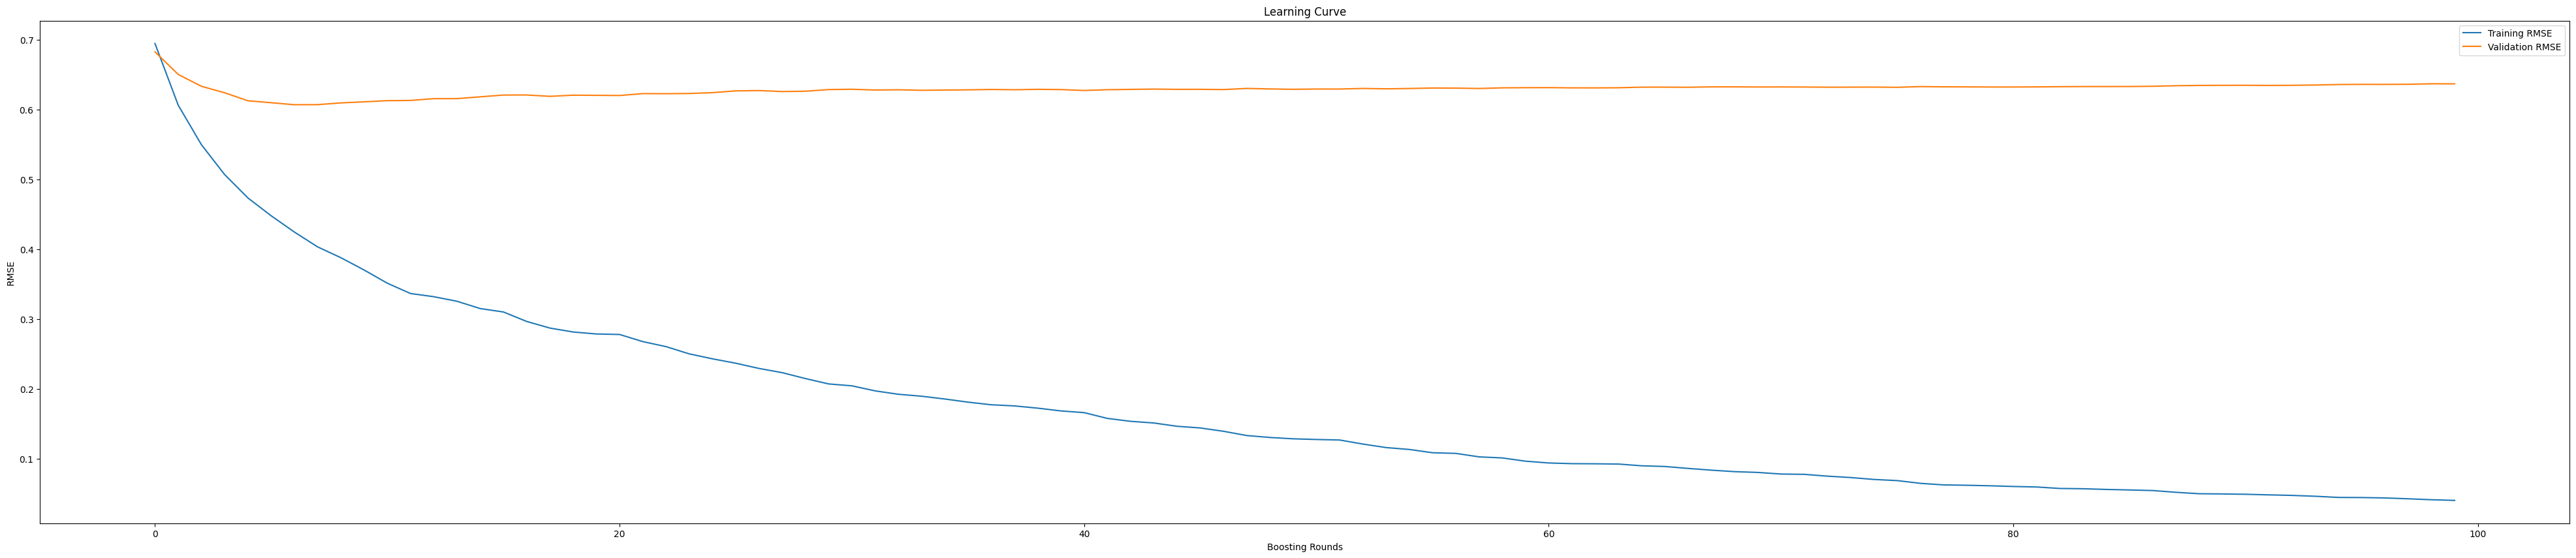

In [ ]:
# Melatih model dengan evaluasi pada set validasi tanpa eval_metric
model = XGBRegressor()

# Melatih model dengan set validasi untuk mendapatkan hasil evaluasi
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Menambahkan set pelatihan dan validasi
    verbose=False  # Nonaktifkan output selama pelatihan
)

# Mendapatkan hasil evaluasi untuk learning curve
results = model.evals_result()

# Menampilkan learning curve
plt.plot(results["validation_0"]["rmse"], label="Training RMSE")
plt.plot(results["validation_1"]["rmse"], label="Validation RMSE")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.title("Learning Curve")
plt.legend()
plt.show()


Training RMSE terus menurun, menunjukkan bahwa model semakin baik dalam menyesuaikan data pelatihan.
Validation RMSE cenderung stabil setelah beberapa putaran, yang bisa mengindikasikan model mulai mendekati titik optimal.
Kesenjangan antara Training RMSE dan Validation RMSE menunjukkan potensi overfitting jika kesenjangan semakin besar.

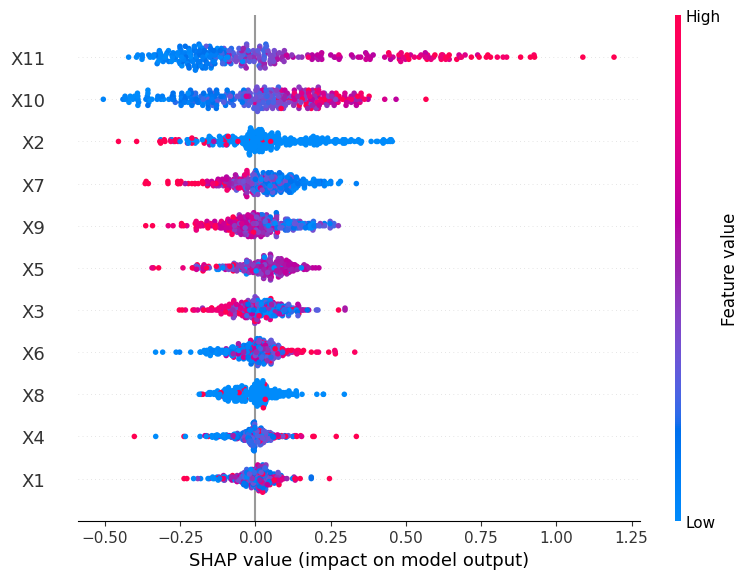

In [ ]:
# Mengimpor pustaka SHAP untuk interpretasi
import shap

# Inisialisasi SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_val)

# Menampilkan plot SHAP values
shap.summary_plot(shap_values, X_val)


X11 dan X10 memiliki dampak terbesar terhadap prediksi, menunjukkan bahwa perubahan nilai pada fitur-fitur ini paling memengaruhi hasil model.
Titik berwarna merah menunjukkan nilai fitur yang tinggi, sedangkan biru menunjukkan nilai rendah.
Untuk beberapa fitur, nilai tinggi (merah) cenderung meningkatkan prediksi, sedangkan nilai rendah (biru) memiliki pengaruh yang berlawanan, dan sebaliknya untuk fitur lain.


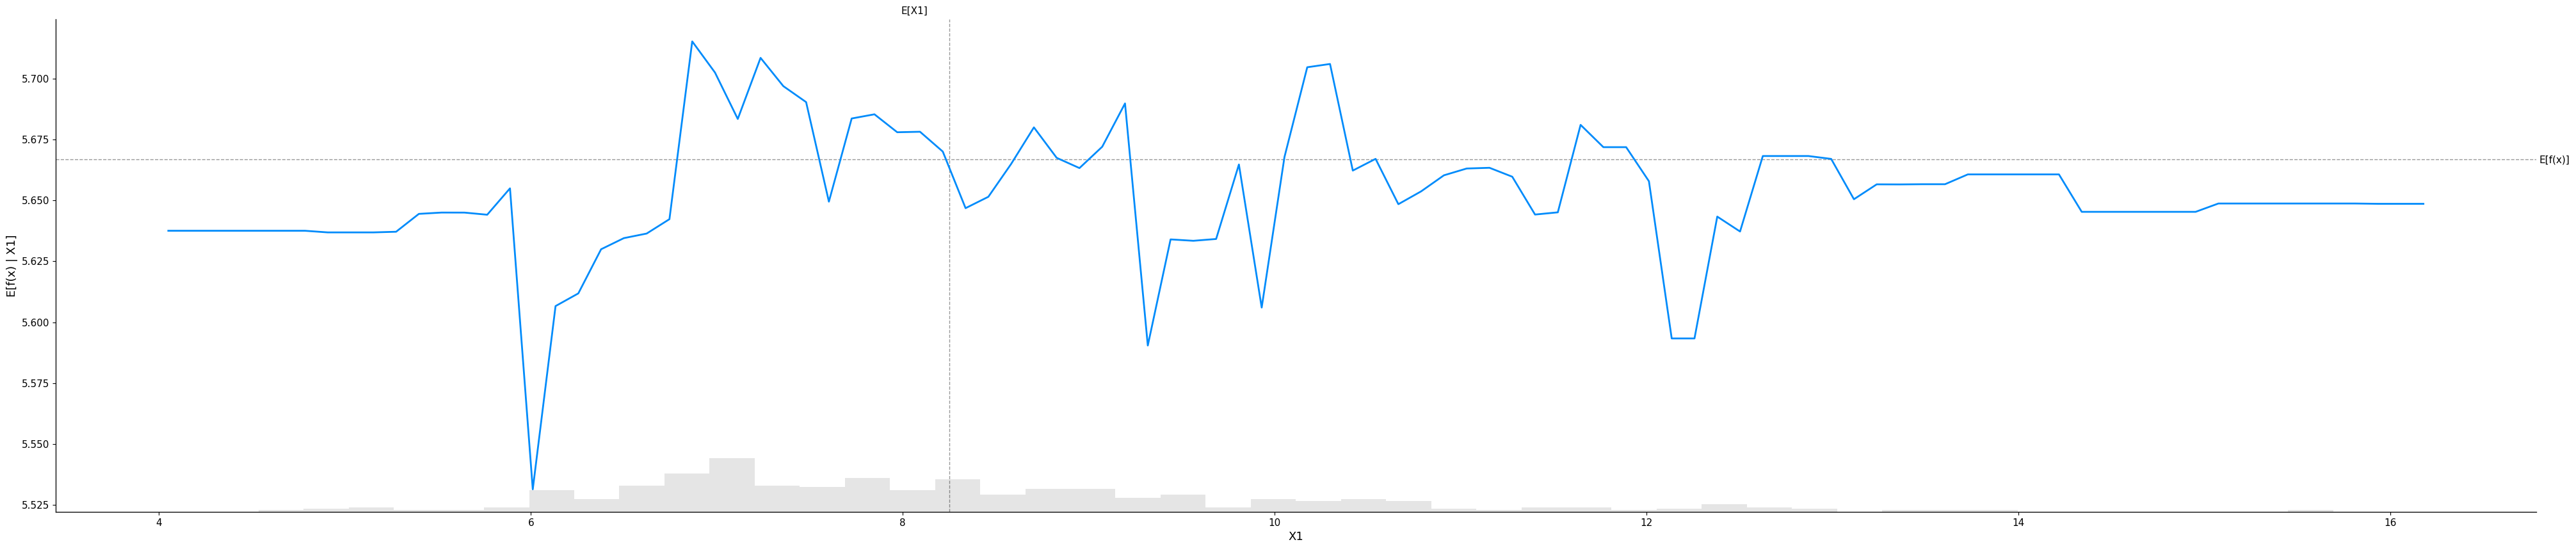

In [ ]:
# Mengimpor pustaka SHAP untuk interpretasi model
import shap

# Inisialisasi SHAP explainer dengan model yang sudah dilatih
explainer = shap.Explainer(model, X_train)

# Menghitung nilai SHAP untuk set validasi
shap_values = explainer(X_val)

# Membuat plot untuk melihat pengaruh fitur tertentu
# Plot untuk fitur pertama (gantilah index sesuai fitur yang ingin ditampilkan)
shap.partial_dependence_plot(0, model.predict, X_val, ice=False, model_expected_value=True, feature_expected_value=True)


Fluktuasi pada grafik menunjukkan bahwa perubahan nilai X11 menyebabkan perubahan signifikan pada prediksi.
Puncak dan lembah di grafik menandakan bahwa nilai tertentu pada X11 dapat meningkatkan atau menurunkan prediksi model secara drastis.
Ini menguatkan bahwa X11 adalah fitur penting dengan pengaruh besar terhadap hasil prediksi.